In [0]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

from scipy.stats import fisher_exact,spearmanr

import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

In [0]:
url_pollution = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSBF0Jz0IZezYodgtLRrQouH9KDuVJ5D3A12KAG263jDJT9xB3gKK7mlei7R316DCsRv1_AY9LVEOyk/pub?gid=1738056038&single=true&output=csv"

In [0]:
url_infections = "https://github.com/pcm-dpc/COVID-19/raw/master/dati-province/dpc-covid19-ita-province.csv"

In [0]:
url_cities = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSBF0Jz0IZezYodgtLRrQouH9KDuVJ5D3A12KAG263jDJT9xB3gKK7mlei7R316DCsRv1_AY9LVEOyk/pub?gid=0&single=true&output=csv"

In [0]:
pollution = pd.read_csv(url_pollution)

pollution = pollution[pollution['Country'] == 'Italy'][['City/Town','Annual mean, ug/m3']]

In [124]:
pollution.head()

,City/Town,"Annual mean, ug/m3"
2270,Acquapendente,14
2271,Acri,21
2272,Adria,35
2273,Alatri,28
2274,Alba,26


In [0]:
infections = pd.read_csv(url_infections)

In [126]:
infections.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0
1,2020-02-24 18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0
2,2020-02-24 18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0
3,2020-02-24 18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0
4,2020-02-24 18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,0.000000,0.000000,0


Converting dates into numbers

In [0]:
FMT = '%Y-%m-%d %H:%M:%S'
date = infections['data']
infections['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

In [128]:
cities = pd.read_csv(url_cities).iloc[:,[4,10]]
 
cities.rename(columns={'Denominazione (Italiana e straniera)':'city','Denominazione dell\'Unità territoriale sovracomunale \n(valida a fini statistici)':'province'},inplace=True)

cities.head(10)

,city,province
0,Abano Terme,Padova
1,Abbadia Cerreto,Lodi
2,Abbadia Lariana,Lecco
3,Abbadia San Salvatore,Siena
4,Abbasanta,Oristano
5,Abbateggio,Pescara
6,Abbiategrasso,Milano
7,Abetone Cutigliano,Pistoia
8,Abriola,Potenza
9,Acate,Ragusa


In [0]:
merged_cities = pd.merge(pollution,cities,left_on=['City/Town'],right_on=['city'])



In [151]:
merged_cities.head()

,City/Town,"Annual mean, ug/m3",city,province
0,Acquapendente,14,Acquapendente,Viterbo
1,Acri,21,Acri,Cosenza
2,Adria,35,Adria,Rovigo
3,Alatri,28,Alatri,Frosinone
4,Alba,26,Alba,Cuneo


Average pollution per province

In [0]:
pollution_series = merged_cities.groupby('province')['Annual mean, ug/m3'].mean()

In [152]:
pollution_series.head()

province
Alessandria      21.750000
Ancona           27.000000
Arezzo           15.500000
Ascoli Piceno    13.666667
Asti             27.000000
Name: Annual mean, ug/m3, dtype: float64

In [0]:
pollution_province = pd.DataFrame({'province':list(pollution_series.index),'Annual mean, ug/m3':list(pollution_series)})

In [148]:
pollution_province.head(10)

,province,"Annual mean, ug/m3"
0,Alessandria,21.750000
1,Ancona,27.000000
2,Arezzo,15.500000
3,Ascoli Piceno,13.666667
4,Asti,27.000000
5,Avellino,35.000000
6,Bari,24.000000
7,Barletta-Andria-Trani,23.000000
8,Belluno,21.000000
9,Benevento,41.000000


# Calculating daily infection rate (average of daily change of total infected people)

In [0]:
infection_rate = pd.DataFrame({'province':[],'infection_rate':[]})

for city in infections['denominazione_provincia'].unique():
  # Only get days when there have been infected people
  subset = infections[(infections['denominazione_provincia'] == city) & (infections['totale_casi'] > 0)].sort_values('data')
  
  # Mean value of the differences between consecutive points
  city_infection_rate =  np.mean(subset['totale_casi'].diff(1)) 
  
  infection_rate = infection_rate.append(pd.DataFrame({'province':[city],'infection_rate':[city_infection_rate]}))

In [134]:
infection_rate.sort_values('infection_rate',ascending=False).head(10)

,province,infection_rate
0,Bergamo,234.040000
0,Brescia,209.416667
0,Milano,186.560000
0,Cremona,107.200000
0,Torino,67.080000
0,Piacenza,67.000000
0,Lodi,62.720000
0,Pesaro e Urbino,49.375000
0,Verona,47.600000
0,Pavia,46.680000


# Joining the datasets by city name

In [0]:
pollution_infections = pd.merge(pollution_province,infection_rate,left_on=['province'],right_on=['province'])[['province','Annual mean, ug/m3','infection_rate']]

In [136]:
pollution_infections.head(10)

,province,"Annual mean, ug/m3",infection_rate
0,Alessandria,21.750000,36.277778
1,Ancona,27.000000,28.150000
2,Arezzo,15.500000,7.105263
3,Ascoli Piceno,13.666667,4.900000
4,Asti,27.000000,6.789474
5,Avellino,35.000000,9.307692
6,Bari,24.000000,9.650000
7,Barletta-Andria-Trani,23.000000,1.823529
8,Belluno,21.000000,11.000000
9,Benevento,41.000000,0.538462


In [137]:
pollution_infections.shape

(96, 3)

# Spearman correlation coefficient 

In [138]:
x = pollution_infections.iloc[:,1]
y = pollution_infections.iloc[:,2]

print(spearmanr(x,y))

SpearmanrResult(correlation=0.41584996654143863, pvalue=2.5134133987041934e-05)


# Correlation plot

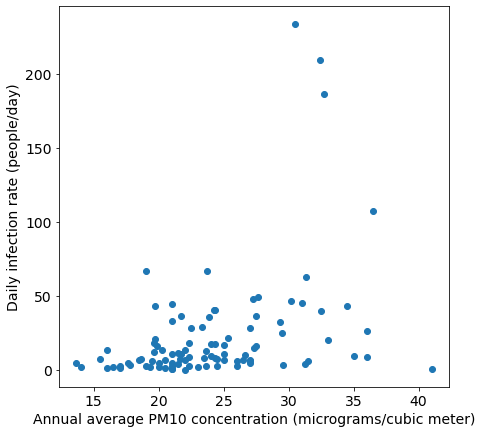

In [139]:
plt.rcParams['figure.figsize'] = [7, 7]

plt.rc('font', size=14) 

plt.scatter(x,y)
plt.xlabel("Annual average PM10 concentration (micrograms/cubic meter)")
plt.ylabel("Daily infection rate (people/day)")
plt.show()

# Average national infection rate

In [0]:
avg_national_infection_rate = np.mean(pollution_infections['infection_rate'])

In [141]:
avg_national_infection_rate

23.108873068129906

# Average national pollution index

In [0]:
avg_national_pollution = np.mean(pollution_infections['Annual mean, ug/m3'])

In [143]:
avg_national_pollution

24.159093915343913

In [0]:
pollution_infections['flag_high_infection_rate'] = [int(x) for x in pollution_infections['infection_rate'] > avg_national_infection_rate]
pollution_infections['flag_high_pollution'] = [int(x) for x in pollution_infections['Annual mean, ug/m3'] > avg_national_pollution]


In [150]:
pollution_infections.head(10)

,province,"Annual mean, ug/m3",infection_rate,flag_high_infection_rate,flag_high_pollution
0,Alessandria,21.750000,36.277778,1,0
1,Ancona,27.000000,28.150000,1,1
2,Arezzo,15.500000,7.105263,0,0
3,Ascoli Piceno,13.666667,4.900000,0,0
4,Asti,27.000000,6.789474,0,1
5,Avellino,35.000000,9.307692,0,1
6,Bari,24.000000,9.650000,0,0
7,Barletta-Andria-Trani,23.000000,1.823529,0,0
8,Belluno,21.000000,11.000000,0,0
9,Benevento,41.000000,0.538462,0,1


# Correlation between pollution and infection

## Crosstab

In [0]:
ctab_poll_inf = pd.crosstab(pollution_infections.flag_high_pollution,pollution_infections.flag_high_infection_rate)

In [146]:
ctab_poll_inf

flag_high_infection_rate,0,1
flag_high_pollution,,
0,45,9
1,24,18


## Fisher's test p-value

In [147]:
fisher_exact(ctab_poll_inf)[1]

0.006117165433063012